In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import cv2

import os
from glob import glob

In [3]:
!pip install torchsummary
from torchsummary import summary

In [4]:
# Cuda GPU
device = 'cuda'

In [5]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transform=None):
        self.transform = transform
        self.data = data_path
        self.label = [int(p.split('/')[-2] == 'santa') for p in data_path]
        self.data_len = len(self.data)
        
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, index):
        image = Image.open(self.data[index], mode='r')
        image = image.convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        self.label[index] = np.array(self.label[index])
        return image, torch.from_numpy(self.label[index])
        
        

In [6]:
train_path = '/kaggle/input/is-that-santa-image-classification/is that santa/train/'
test_path = '/kaggle/input/is-that-santa-image-classification/is that santa/test/'

train_image_path = glob(os.path.join(train_path, '*', '*')) # 하위폴더 2개라서 * 2개
test_image_path = glob(os.path.join(test_path, '*', '*'))

#  glob 함수는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환한다.

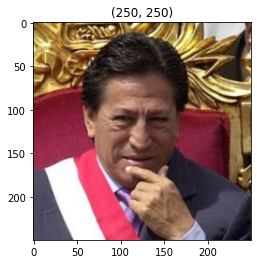

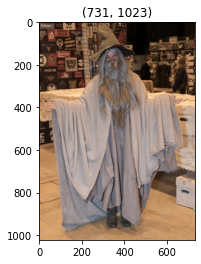

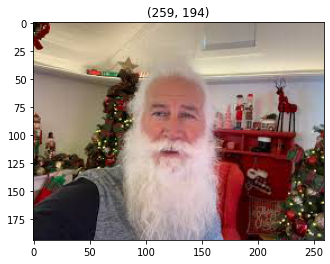

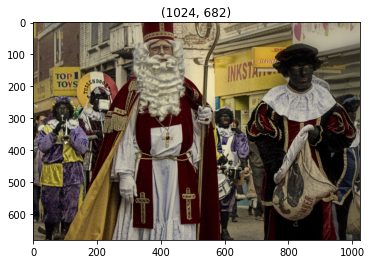

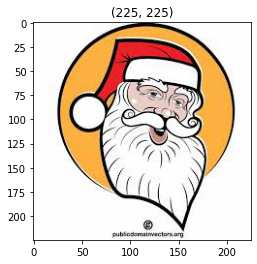

In [7]:
for _ in range(5):
    idx = np.random.randint(0, len(train_image_path))
    image = Image.open(train_image_path[idx])
    plt.imshow(image)
    plt.title(image.size)
    plt.show()

In [8]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

In [9]:
trainData = CustomDataset(train_image_path, transform=transform)
testData = CustomDataset(test_image_path, transform=transform)

In [10]:
from torch.utils.data import DataLoader
trainLoader = DataLoader(dataset=trainData, batch_size=64, shuffle=True)
testLoader = DataLoader(dataset=testData, batch_size=64, shuffle=False)

In [11]:
def train(model, trainLoader):
    model.train()
    train_loss = 0
    train_acc =0
    for image, label in trainLoader:
        image, label = image.to(device), label.to(device)
        output = model(image)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += (torch.argmax(output, dim=1) == label).sum().item()
    train_loss /= len(trainLoader)  
    train_acc /= len(trainLoader.dataset)
    return train_loss , train_acc

In [12]:
def test(model, testLoader):
    test_loss = 0
    test_acc = 0
    model.eval()
    with torch.no_grad():
        for image, label in testLoader:
            image, label = image.to(device), label.to(device)
            output = model(image)
            loss = criterion(output, label)

            test_loss += loss.item()
            test_acc += (torch.argmax(output, dim=1) == label).sum().item()
        
    test_loss /= len(testLoader)
    test_acc /= len(testLoader.dataset)
    return test_loss, test_acc

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.block1 = nn.Sequential(nn.Conv2d(3,32, kernel_size=4,stride=1, padding=1),
                                   nn.LeakyReLU(),
                                    nn.BatchNorm2d(32),
                                    nn.MaxPool2d(kernel_size=3,stride=2)
                                   
                                   )
        self.block2 = nn.Sequential(nn.Conv2d(32,64, kernel_size=4,stride=1, padding=1),
                                   nn.LeakyReLU(),
                                    nn.BatchNorm2d(64),
                                    nn.MaxPool2d(kernel_size=3,stride=2)
                                   
                                   )
        
        self.fc = nn.Linear(186624, 2)
        
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x

In [14]:
cnn = CNN().to(device)

In [15]:
summary(cnn, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 223, 223]           1,568
         LeakyReLU-2         [-1, 32, 223, 223]               0
       BatchNorm2d-3         [-1, 32, 223, 223]              64
         MaxPool2d-4         [-1, 32, 111, 111]               0
            Conv2d-5         [-1, 64, 110, 110]          32,832
         LeakyReLU-6         [-1, 64, 110, 110]               0
       BatchNorm2d-7         [-1, 64, 110, 110]             128
         MaxPool2d-8           [-1, 64, 54, 54]               0
            Linear-9                    [-1, 2]         373,250
Total params: 407,842
Trainable params: 407,842
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 58.58
Params size (MB): 1.56
Estimated Total Size (MB): 60.71
-----------------------------------------

In [16]:
# 손실 함수
criterion = nn.CrossEntropyLoss()
# 옵티마이저
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.00006)

In [17]:
N_EPOCH = 5

for epoch in range(1, N_EPOCH+1):
    print(f'EPOCH {epoch}')
    loss, accuracy = train(cnn, trainLoader)
    val_loss, val_accuracy = test(cnn, testLoader)
    
    print('Train | Loss : {:7.4f}, Accuracy : {:6.2f} %'.format(
        loss, accuracy*100))
    print('Validation | Loss : {:7.4f}, Accuracy : {:6.2f} %\n'.format(
        val_loss, val_accuracy*100))

EPOCH 1
Train | Loss :  0.7306, Accuracy :  81.92 %
Validation | Loss :  0.7597, Accuracy :  56.98 %

EPOCH 2
Train | Loss :  0.3075, Accuracy :  91.37 %
Validation | Loss :  0.5978, Accuracy :  74.51 %

EPOCH 3
Train | Loss :  0.0834, Accuracy :  97.07 %
Validation | Loss :  0.4017, Accuracy :  82.14 %

EPOCH 4
Train | Loss :  0.0499, Accuracy :  98.53 %
Validation | Loss :  0.3300, Accuracy :  87.99 %

EPOCH 5
Train | Loss :  0.0183, Accuracy :  99.19 %
Validation | Loss :  0.3609, Accuracy :  90.58 %



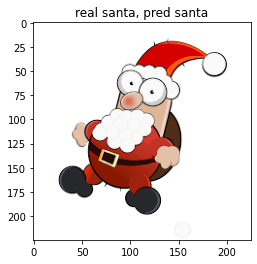

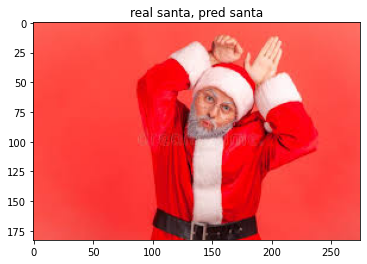

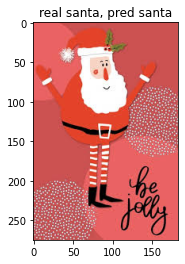

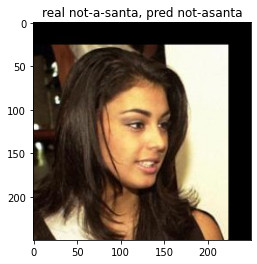

In [18]:
for _ in range(4):
    rnd_idx = np.random.randint(0, len(test_image_path))
    label = test_image_path[rnd_idx].split('/')[-2]
    image_path = test_image_path[rnd_idx]
    
    image =Image.open(image_path, mode='r')
    test_image = image.convert('RGB')
    test_image = transform(test_image)
    
    pred = cnn(torch.unsqueeze(test_image.to(device), 0))
    pred_label = 'santa' if torch.argmax(pred, dim=1).item() == 1 else 'not-asanta'
    
    plt.imshow(image)
    plt.title(f'real {label}, pred {pred_label}')
    plt.show()

In [19]:
googlenet = torchvision.models.googlenet(pretrained=True)
googlenet.fc.out_features=2
googlenet = googlenet.to(device)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [20]:
summary(googlenet,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(googlenet.parameters(), lr=0.006)

In [30]:
%%time
epochs = 5

for epoch in range(epochs):
    print(f'epoch {epoch}')
    loss, accuracy = train(googlenet, trainLoader)
    val_loss, val_accuracy = test(googlenet, testLoader)
    
    
    print('train,loss {:7.4f}, accuracy {:7.4f} %'.format(loss, accuracy*100))
    print('test,loss {:7.4f}, accuracy {:7.4f} %'.format(val_loss, val_accuracy*100))

epoch 0


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


train,loss  1.4559, accuracy 76.3844 %
test,loss 33.4538, accuracy 47.2403 %
epoch 1
train,loss  0.2608, accuracy 86.9707 %
test,loss 14.2556, accuracy 60.7143 %
epoch 2
train,loss  0.2275, accuracy 91.0423 %
test,loss  1.9639, accuracy 89.7727 %
epoch 3
train,loss  0.2001, accuracy 92.1824 %
test,loss  1.0451, accuracy 84.5779 %
epoch 4
train,loss  0.1774, accuracy 92.9967 %
test,loss  0.4652, accuracy 85.7143 %
CPU times: user 1min 44s, sys: 13.5 s, total: 1min 57s
Wall time: 2min 1s


In [31]:
test_image_path[rnd_idx]

'/kaggle/input/is-that-santa-image-classification/is that santa/test/not-a-santa/287.not-a-santa.jpg'

In [32]:
test_image_path[rnd_idx].split('/')

['',
 'kaggle',
 'input',
 'is-that-santa-image-classification',
 'is that santa',
 'test',
 'not-a-santa',
 '287.not-a-santa.jpg']

In [33]:
test_image_path[rnd_idx].split('/')[-2]

'not-a-santa'

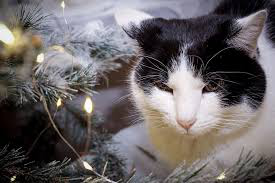

In [34]:
image

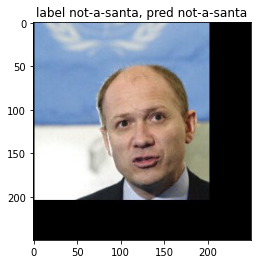

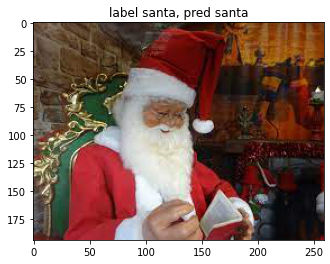

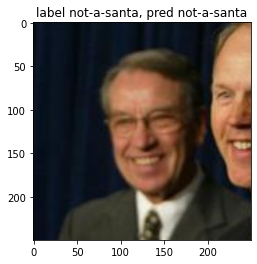

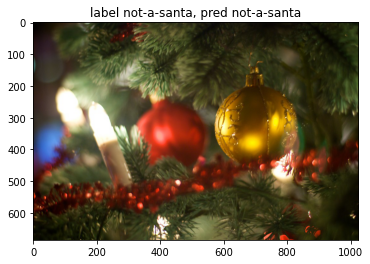

In [35]:
for _ in range(4):
    rnd_idx = np.random.randint(0, len(test_image_path))
    label = test_image_path[rnd_idx].split('/')[-2]
    image_path = test_image_path[rnd_idx]
    
    image = Image.open(image_path, mode='r')
    test_image = image.convert('RGB')
    test_image = transform(test_image)
    
    prediction = googlenet(torch.unsqueeze(test_image.to(device), 0))
    pred_label = 'santa' if torch.argmax(prediction, dim=1).item() == 1 else 'not-a-santa'
    
    plt.title(f'label {label}, pred {pred_label}')
    plt.imshow(image)
    plt.show()